## CAIXABANK Hackathon - Data Science

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Data_Science_&_AI/NUWE/"
train_data_dir_csv = [project_path + 'Data/CSV/' + x for x in os.listdir(project_path+'Data/CSV') if 'train' in x]
test_data_dir_csv = [project_path + 'Data/CSV/' + x for x in os.listdir(project_path+'Data/CSV') if 'test' in x][0]
train_data_dir_pdf = [project_path + 'Data/pdf/' + x for  x in os.listdir(project_path+'Data/pdf')]
train_data_api = project_path + 'Data/json/links.txt'

### IMPORT MODULES

In [108]:
import pandas as pd
import math
import scipy as sp
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import warnings

from utils import utils, sentiment_tweet, train


### DATA LOAD

#### STOCK

In [94]:
path_stock, extension_stock = utils.get_path('test_yahoo.csv')
df_stock = utils.get_dataframe(path_stock, extension_stock)
df_stock.head(2)

,Unnamed: 0,date,open,close,%,volume,Y,target
0,0,1993-07-12,2826.800049,2826.399902,-0.014155,0.0,2,3.0
1,1,1993-07-13,2826.399902,2843.399902,0.601472,0.0,3,2.0


#### TWEETS

In [95]:
df_twitter = pd.DataFrame(['hola', 'bueno', 'malo', 'me encanta', "@master en https://magic.com #marvella", 'jajajaja', 'enfin', 'hooolaa'], columns=['tweet'])
df_twitter = sentiment_tweet.apply_vader(df_twitter)
df_twitter['date'] = ['2018-04-29', '2019-04-29', '2017-04-29', '2020-04-29', '2021-04-29', '2018-06-29', '2017-08-29', '2017-10-29']
df_twitter.head(2)


Invalid translation: hooolaa


,tweet,clean,sentiment,date
0,hola,hola,0.0000,2018-04-29
1,bueno,bueno,0.4404,2019-04-29


## PYTRENDS

In [96]:
path_pytrends, extension_pytrends = utils.get_path('pytrends_data.csv')
df_pytrends = utils.get_dataframe(path_pytrends, extension_pytrends)
df_pytrends.head(2)

,date,Ibex 35,ibex 35 down,credito,recesión,Ibex 35%,ibex 35 down%,credito%,recesión%
0,2017-04-29,6,0,60,0,-88.46,0.0,-30.23,-100.0
1,2017-04-30,3,0,48,13,-49.99,0.0,-20.00,1300000.0


#### COMBINE DATA

##### select columns a algun lloc
##### netejar funcions mo utilitzades tot el codi
##### fitxere requeerimeentss


In [97]:
df_global = df_pytrends.set_index('date').join(df_stock.set_index('date'))
df_global_twitter = df_global.join(df_twitter.set_index('date'))
df_global_twitter.sentiment = df_global_twitter.sentiment.fillna(0)
df_global_twitter.tail(2)

,Ibex 35,ibex 35 down,credito,recesión,Ibex 35%,ibex 35 down%,credito%,recesión%,Unnamed: 0,open,close,%,volume,Y,target,tweet,clean,sentiment
date,,,,,,,,,,,,,,,,,,
2022-05-24,72,49,90,16,7.46,4900000.0,2.27,0.00,7443.0,8537.799805,8631.200195,1.093963,207033000.0,3.0,3.0,NaN,NaN,0.0
2022-05-25,0,0,0,0,-100.00,-100.0,-100.00,-99.99,7444.0,8723.099609,8760.200195,0.425314,203488200.0,3.0,3.0,NaN,NaN,0.0


In [98]:
df_global#.loc['2018']

,Ibex 35,ibex 35 down,credito,recesión,Ibex 35%,ibex 35 down%,credito%,recesión%,Unnamed: 0,open,close,%,volume,Y,target
date,,,,,,,,,,,,,,,
2017-04-29,6,0,60,0,-88.46,0.0,-30.23,-100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-30,3,0,48,13,-49.99,0.0,-20.00,1300000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-01,11,0,53,12,266.58,0.0,10.42,-7.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-02,52,0,89,16,372.69,0.0,67.92,33.33,6148.0,10737.700195,10820.299805,0.769249,225313300.0,3.0,3.0
2017-05-03,53,0,89,16,1.92,0.0,0.00,0.00,6149.0,10793.000000,10837.000000,0.407672,192962800.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-21,7,0,67,19,-89.55,-100.0,-21.18,26.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-22,6,0,54,9,-14.28,0.0,-19.40,-52.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-23,67,0,88,16,1016.50,0.0,62.96,77.77,7442.0,8600.400391,8625.799805,0.295328,166876400.0,2.0,3.0


### EDA

In [99]:
df_global['Ibex35_30'] = df_global[['Ibex 35']].apply(lambda group: group.rolling(30).sum())
df_global['Ibex35_90'] = df_global[['Ibex 35']].apply(lambda group: group.rolling(90).sum())
df_global['Ibex35_7'] = df_global[['Ibex 35']].apply(lambda group: group.rolling(7).sum())
df_global['credito_30'] = df_global[['credito']].apply(lambda group: group.rolling(30).sum())
df_global['credito_90'] = df_global[['credito']].apply(lambda group: group.rolling(90).sum())
df_global['credito_7'] = df_global[['credito']].apply(lambda group: group.rolling(7).sum())
df_global['recesion_30'] = df_global[['recesión']].apply(lambda group: group.rolling(30).sum())
df_global['recesion_90'] = df_global[['recesión']].apply(lambda group: group.rolling(90).sum())
df_global['recesion_7'] = df_global[['recesión']].apply(lambda group: group.rolling(7).sum())


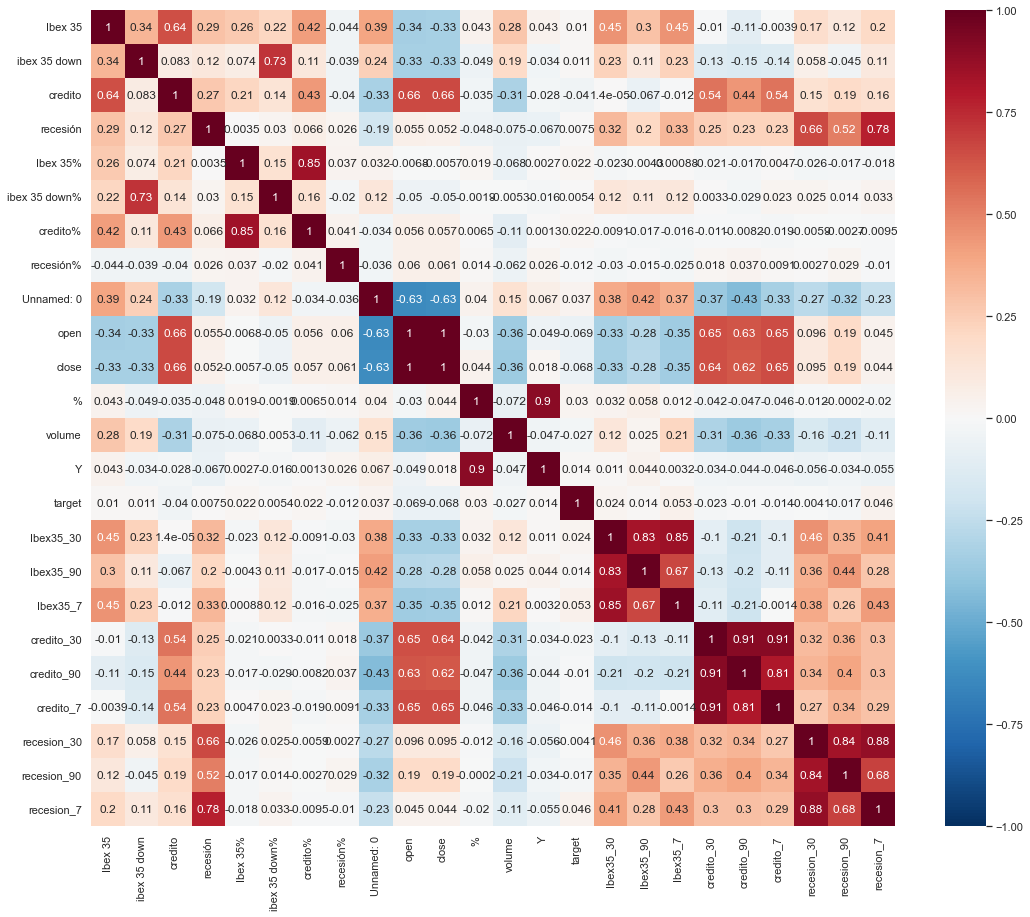

In [100]:
correlation = df_global.corr()
#display(correlation)
plt.figure(figsize=(18,15))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

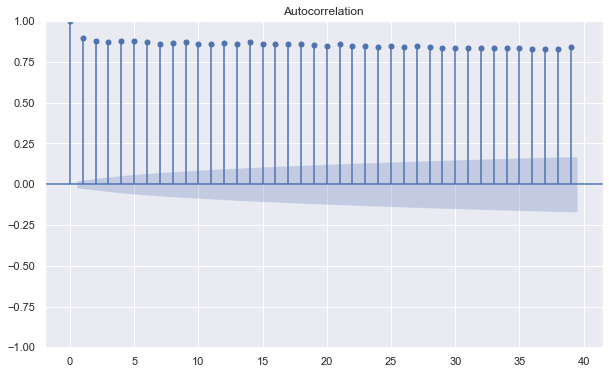

In [101]:
plt.rc("figure", figsize=(10,6))
sm.graphics.tsa.plot_acf(df_stock.close);

In [102]:
#drawing one figure with title and 3 axes below each other. Size and resolution are specified
f, axes = plt.subplots(3,1,figsize=(18,12),dpi=600,sharex=True)
plt.suptitle('Comparison of unscaled features at different scales',fontsize=22);

#drawing boxplots of three different scales, each to separate axis
sns.boxplot(data=df_stock.iloc[:,1:26], ax=axes[0])
sns.boxplot(data=df_stock.iloc[:,1:26], ax=axes[1]).set(ylim=(-15,50))
sns.boxplot(data=df_stock.iloc[:,1:26], ax=axes[2]).set(ylim=(-10,10))

#rotating ticks of the shared x axis by 90 degrees. The shared x axis is located on axes[2]
for tick in axes[2].get_xticklabels():
        tick.set_rotation(90);

#setting y axis labels for each axis
for a in axes:
    a.set_ylabel('Unscaled values');

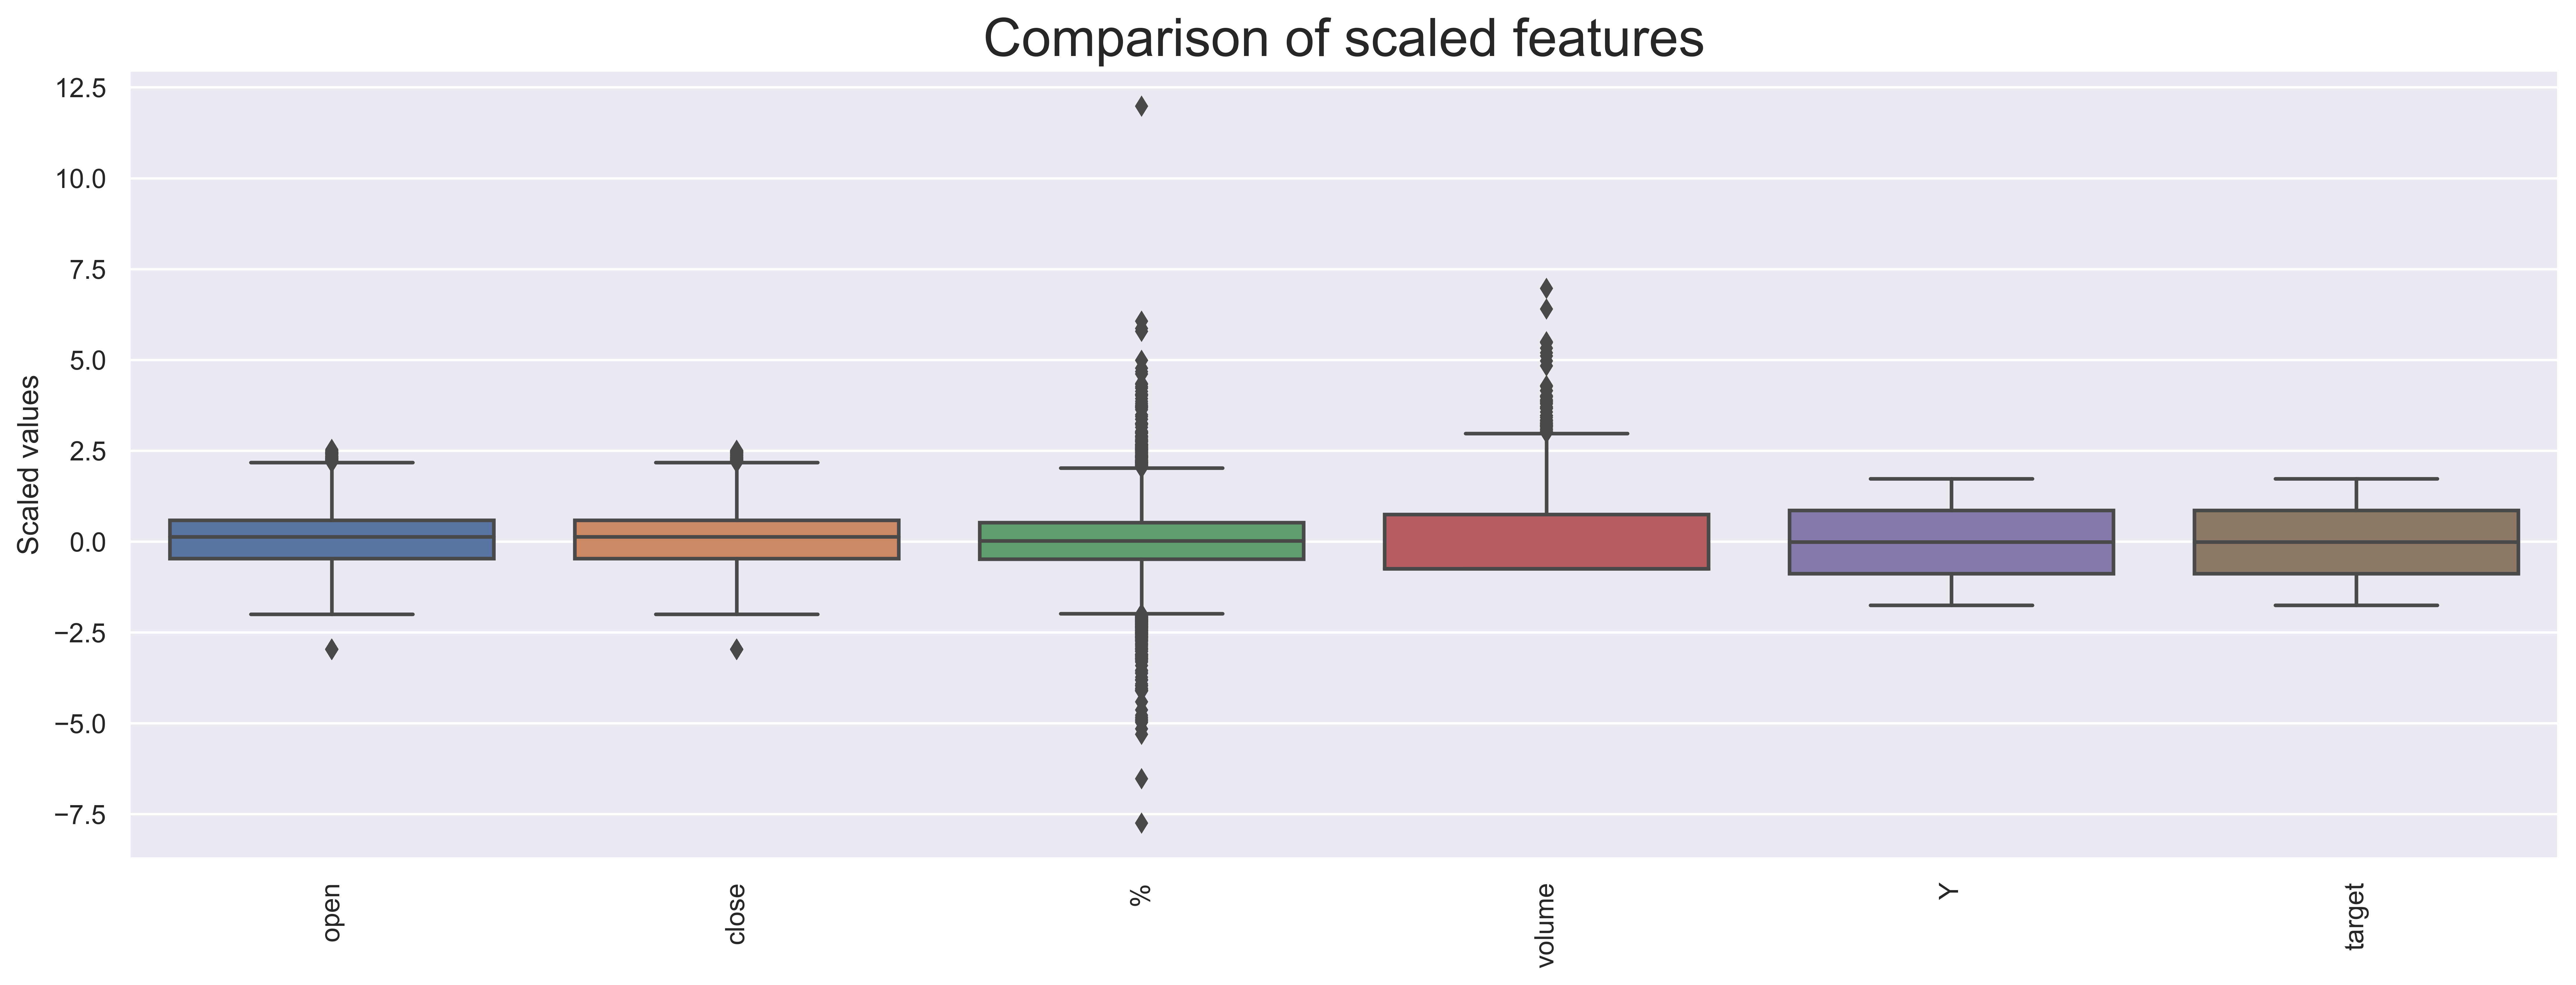

In [103]:
#creating new dataframe for scaled feature values by first copying the original dataframe
df_features_scaled = df_stock.iloc[:,2:26].copy()

#substituting unscaled feature values by scaled values using sklearn StandardScaler
scaler = StandardScaler()
df_features_scaled.iloc[:,:] = scaler.fit_transform(df_features_scaled.iloc[:,:])

#drawing figure with title and single axis. Size and resolution are specified
plt.figure(figsize=(18,6),dpi=600);
plt.title('Comparison of scaled features',fontsize=22);

#setting y axis label
plt.ylabel('Scaled values');

#rotating x axis ticks by 90 degrees
plt.xticks(rotation=90);

#drawing boxplot of scaled feature values
sns.boxplot(data=df_features_scaled);

In [104]:
df_global.columns
df = df_global[['credito','close','volume','Ibex 35']]
df['date'] = df.index
df.index = [x for x in range(df.shape[0])]
df['index'] =df.index.astype(np.int64)
df

/var/folders/r7/669zllp50w3dt5hksf5_4bsw0000gn/T/ipykernel_1784/4065548797.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
/var/folders/r7/669zllp50w3dt5hksf5_4bsw0000gn/T/ipykernel_1784/4065548797.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index'] =df.index.astype(np.int64)


,credito,close,volume,Ibex 35,date,index
0,60,NaN,NaN,6,2017-04-29,0
1,48,NaN,NaN,3,2017-04-30,1
2,53,NaN,NaN,11,2017-05-01,2
3,89,10820.299805,225313300.0,52,2017-05-02,3
4,89,10837.000000,192962800.0,53,2017-05-03,4
...,...,...,...,...,...,...
1938,67,NaN,NaN,7,2022-05-21,1938
1939,54,NaN,NaN,6,2022-05-22,1939
1940,88,8625.799805,166876400.0,67,2022-05-23,1940
1941,90,8631.200195,207033000.0,72,2022-05-24,1941


## MODELS

https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html

https://github.com/jdb78/pytorch-forecasting

In [109]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [110]:
data.info()
data.describe()
data.labor_day


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 0 to 6650
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   agency                            21000 non-null  category      
 1   sku                               21000 non-null  category      
 2   volume                            21000 non-null  float64       
 3   date                              21000 non-null  datetime64[ns]
 4   industry_volume                   21000 non-null  int64         
 5   soda_volume                       21000 non-null  int64         
 6   avg_max_temp                      21000 non-null  float64       
 7   price_regular                     21000 non-null  float64       
 8   price_actual                      21000 non-null  float64       
 9   discount                          21000 non-null  float64       
 10  avg_population_2017               21000 non-nul

0       -
238     -
237     -
236     -
235     -
       ..
6765    -
6764    -
6763    -
6771    -
6650    -
Name: labor_day, Length: 21000, dtype: category
Categories (2, object): ['-', 'labor_day']

In [111]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [112]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()


/usr/local/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


293.0088195800781

In [113]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
/usr/local/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.7k


/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/puche99/Desktop/helpers/hackathons/CaixaBank_DS/.lr_find_91b31659-eb39-4058-b0d0-dba2eafbe088.ckpt
/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1718: UserWarning: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None, 'save_on_train_epoch_end': None}"].
  rank_zero_warn(


suggested learning rate: 0.01862087136662867


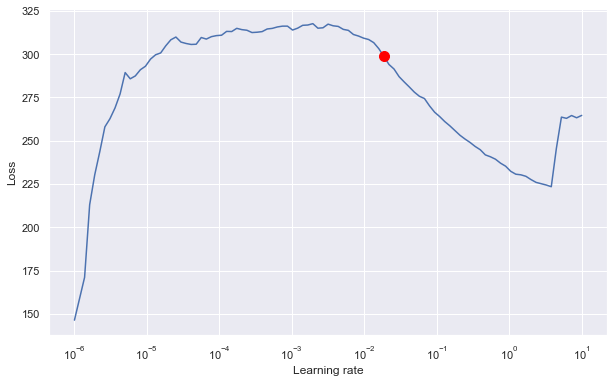

/var/folders/r7/669zllp50w3dt5hksf5_4bsw0000gn/T/ipykernel_1784/450857479.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [114]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [115]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=3,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.7k


In [116]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Missing logger folder: lightning_logs/lightning_logs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [117]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-05-28 03:23:02,599] A new study created in memory with name: no-name-e486e023-c8b1-4b88-8f82-892e63f9efeb
/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `n

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [ ]:
best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="quantiles",
)

In [ ]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);

In [ ]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [ ]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [ ]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "discount_in_percent", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

In [ ]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);

#### RESULTS

## NEXT STEPS